# LED Display Reflectance and Precision Analysis

Prepared by the Entertainment Technology Center @ USC, based on preparation
and measurements taken in January of 2023. 

This document shows the main types of color analysis and error plots published
previously in the [ETC LED Display report, 2023](https://tinyurl.com/ETC2023-LED-report). 

For questions please contact [Ritchie Argue, ledeval@doequalsglory.com](mailto:ledeval@doequalsglory.com)

## Basic display measurement

This project includes a script to generate display measurement files. This
process requires two computers, one to run the test pattern generator, and
another to connect to the spectrometer and make measurements. This project
should be installed on the main computer connected to the spectrometer. 

The measurement script can be run like the following:

```zsh
python -m colour_workbench.scripts.measure_display --tpg-ip <TPG Computer IP>
```

The `measure_display` script has many configuration options, but in it's basic
form will automatically connect to the TPG computer and spectrometer. After
measuring a series of color patches, which takes about 3 hours, it will output
the display measurements to an automatically generated filename. 

You can use the `--help` option to see the full list of options, which mainly
include ways to change the list of sample colors that will be measured.

## PDF generation

A measurement file can be analyzed and turned into a summary PDF by running the
`analyze_display_measurements` script.

```sh
python -m colour_workbench.scripts.analyze_display_measurements <FILE NAME>
```

### Scripted analysis

If you want to run your own analysis or inspect the measurements, open a new
.ipynb or python file and you can use elements of this document as a template.

In [1]:
from specio.fileio import load_measurements
from colour_workbench.ETC.analysis import ColourPrecisionAnalysis

measurements = load_measurements("data/demo_measurements.csmf")

# It's recommended to access the raw measurement data via the
# ColourPrecisionAnalysis. It filters out data that has too low of a signal
# quality to be useful among other things. 

data = ColourPrecisionAnalysis(measurements)

/Users/tucker/Dev/colour-workbench/colour_workbench/ETC/analysis.py:88: RuntimeWarning: divide by zero encountered in log10
  snr = 10 * np.log10(
/Users/tucker/Dev/colour-workbench/submodules/colour-science/colour/utilities/verbose.py:263: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
/Users/tucker/Dev/colour-workbench/submodules/colour-science/colour/utilities/verbose.py:263: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028


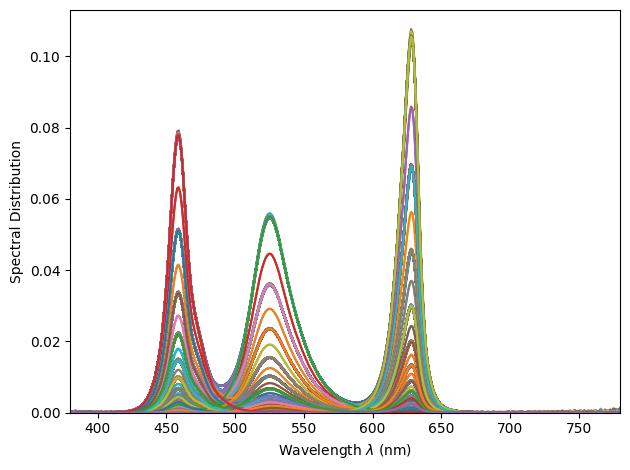

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [2]:
# First we are going to suppress some warnings for this document:

from colour.utilities import suppress_warnings
suppress_warnings(python_warnings=True,colour_usage_warnings=True, colour_runtime_warnings=True)

# We can show a plot of all the spectral measurements

from colour.plotting import plot_multi_sds
plot_multi_sds([m.spd for m in data.measurements], legend=False)

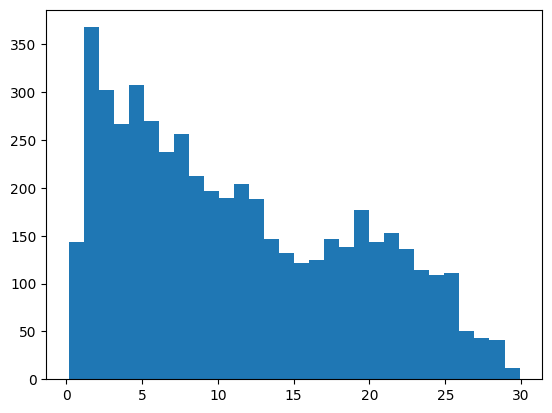

In [3]:
# Another useful plot is showing the histogram of all the dITP errors

import matplotlib.pyplot as plt

plt.hist(data.error["ICtCp"], bins=30)
plt.show()

### Chromaticity Error

The first plot shown in the ETC LED Report PDF is the chromaticity error. 

In this plot the "MacAdam" ellipses are shown along side a series of errors
denoting the color error in each region of the chromaticity diagram. The arrows
and the ellipses are magnified by 10x, as is typical with MacAdam presentations.
Some researchers, including MacAdam himself, feel that a color error 3-4  times 
MacAdam Elapses radius is a "just noticeable difference." 

Modern color researchers no longer use this as a JND metric, but it can be a
useful presentation. If the arrows and ellipses are roughly the same size and
orientation that corresponds to an error of 1 MacAdam E.

It can be generated by the following code:

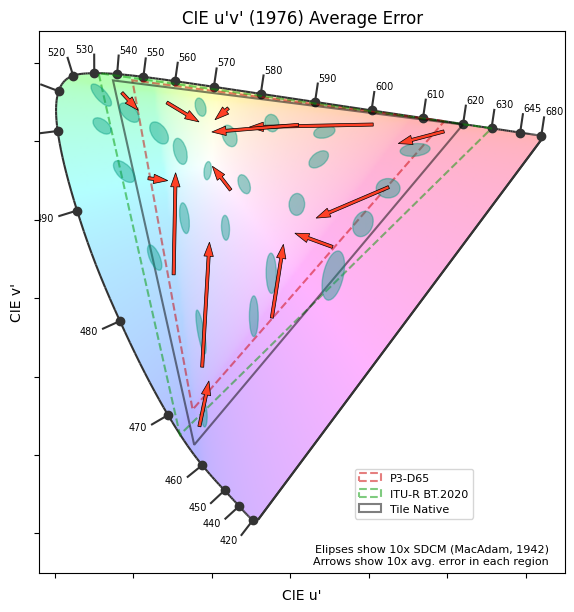

In [4]:
from colour_workbench.ETC.pdf import plot_chromaticity_error

plot_chromaticity_error(data)
plt.show()

### EOTF Tracking

The next plot shows the tiles accuracy in tracking the PQ EOTF.

The purple line shows the tile maximum luminance. Above this value we EXPECT the
display to clip (when metadata and soft-roll off are disabled). The green line
shows a convenient reference point for readers at 1,000 nits. 

The X-axis shows 10-bit code values, while the Y axis shows the display
luminance. Luminance is shown in log base-2, which is helpful for understanding
the dynamic range of the display or signal in terms of exposure "stops"

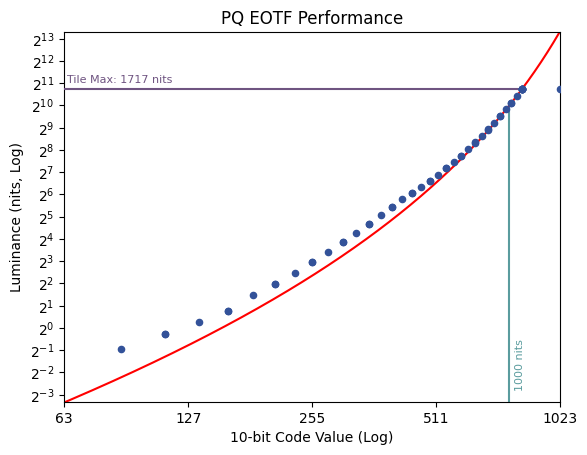

In [5]:
from colour_workbench.ETC.pdf import plot_eotf_accuracy

plot_eotf_accuracy(data)
plt.show()

### White Point Tracking Accuracy

Most video standards specify D65 as the display white point, which means an RGB
value where all three values are the same should produce the chromaticity
(0.1978, 0.3122) in uv or (0.3127, 0.3290) in xy chromaticity. 

At lower brightness values some displays will get pinkish or greenish, or their
color temperature will drift towards blue / yellow. In this plot, a red /
yellow / green guide is shown in the background to help educate readers about
noticeable color differences. The guidelines are based on 2 and 4 JND based on
ANSI C78.377 

In the top subplot, the color temperature error is based on the tile maintaining a
color temperature equivalent to D65, 6504K. The lower subplot is based on
maintaining the same pink / green offset (also known as ∆uv) 

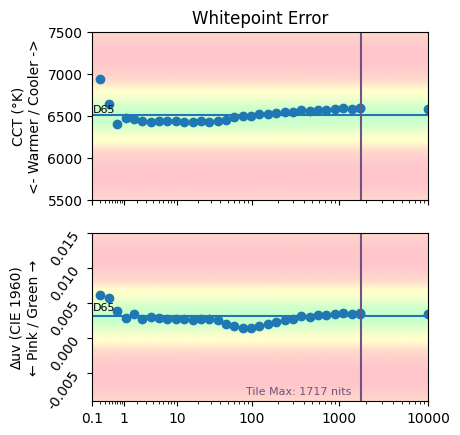

In [6]:
from colour_workbench.ETC.pdf import plot_wp_accuracy

plot_wp_accuracy(data)
plt.show()

### Brightness Error

The next plot in our analysis shows the brightness error scaled to the dITP
color difference model. Finally, for the particular measurements contained in
this file, this plot finally shows us some interesting performance
characteristic. 

In this plot the red / yellow / green guide roughly shows 1, 4, and 8 JND. These
values are scaled from the dITP color difference metric. It's important to keep
in mind that there isn't a single value of acceptance when it comes to color
difference metrics. In many real image viewing scenarios, a ∆I of 5-6 may not be
noticeable. In other scenarios, a difference of 2-3 is obvious. 

If all of the measurements shown on this plot are in the green - yellow region,
it's indicates reasonable performance for most scenarios. The y-axis is shown in
logarithmic scale, once measurements are shown in the red-zone it's very likely
that they are creating noticeable distortions in the tone scale of the image.

The shape or trend of this error may help indicate what types of 1D or 3D LUTs
can correct this error. Errors tending towards the top of the plot are showing
that the measured color is brighter than the intended color, and towards the
bottom, the measured color is darker than the intended color.

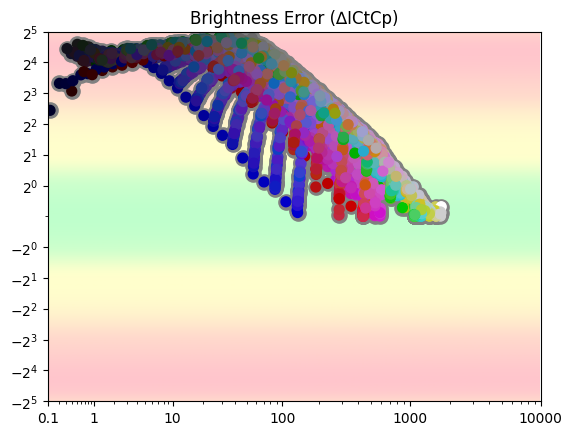

In [7]:
from colour_workbench.ETC.pdf import plot_brightness_errors
plot_brightness_errors(data)
plt.show()

### Chroma Error

The last plot on the analysis report shows the chroma error, in this plot the
brightness error has been removed and only the error in hue and saturation is
included. Chroma is scaled to be more relevant to perception. 

Due to the nature of chroma measurement, this plot does not show positive and
negative error. Only the total amount of error. Chroma is analogous to hue and
saturation combined.

In this example data, the LED tile has a wide range of chroma errors and little
relationship between the hues. It's likely that this LED tile is not configured
in the correct gamut.

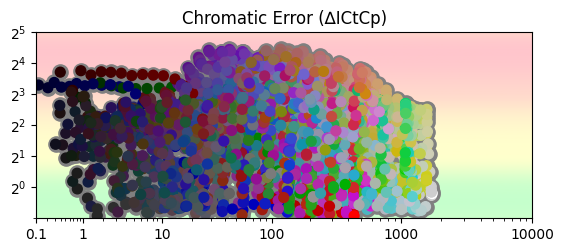

In [8]:
from colour_workbench.ETC.pdf import plot_chromatic_error

plot_chromatic_error(data)
plt.show()

### Color Error Statistics

The last information shown on the analysis document is the image statistics.
They can be shown in-code or in a python notebook (like this document) with the
code below.

The three color error statistics are ∆XYZ, ∆dITP, and ∆dE2000. ∆XYZ is not a
perceptual color difference metric but shows the total physical error and is
sometimes helpful for colour-engineers to debug other color algorithms. 

dITP is a perceptual color difference metric proposed by Dolby and standardized
by ITU in BT-2124. ITP is an extremely sensitive color metric which under the
most extreme and ideal circumstances shows 1 JND. But for moving or complex
imagery, the noticeable difference threshold is higher. 

The mean dITP error correlates to the average display performance across the
entire color volume, while the 95th percentile correlates more with the maximum
error.

dE2000 is similar to dITP in that it is a perceptual color difference metric,
but it is less sensitive than dITP and makes some assumptions about the viewing
conditions. For normal complexity or moving imagery, typical observers are less
sensitive to minute color differences. These minute color differences at low
brightness are not usually perceptible for normal observers and conditions, but
are included in and can inflate dITP error. 

Between both dITP and dE2000, one is not better than the other. ITP can be
useful for understanding physical error in a logarithmic scale, which is
important for understanding the dynamic range or maximum / minimum exposure
range a display is capable of reproducing. Whereas dE2000 is better at
understanding how a human observer checking over the display imagery might
perceive it.

In [9]:
print(data)


Error Data for e5854aee
    Mean dXYZ:    20.41    95% <  33.41
    Mean dITP:    11.35    95% <  24.97
    Mean dE2000:   3.71    95% <   9.92



### Reflectance data

The LED reports published by the Entertainment Technology Center Virtual
Production Working Group in January include reflectance characteristics for the
LED tiles which must me measured seperately than automated display measurements.

Reflectance is an important display characteristic because it determines the
black level of an LED display. In a color measurement lab, the the dynamic range
of a display can be measured to approach infinity. Dynamic range is the ratio of
the brightest a display area can be divided by the darkest a display can be. In
a lab with no ambient light, the LEDs can reach complete black where they don't
emit any light. Meaning that the dynamic range of a 1500 nit LED tile, is
1500/0. 

Instead, in actual usage scenarios the black level of a display is determined by
how much of the ambient light is being reflected by the display. Reflectance is
measured in particular geometries and depends on the angle of the light source
and the angle of the camera or observer. Reflectance measurements are normally
denoted in the following pattern *influx angle*:*measurement angle* where 0° is
tne normal angle perpendicular to the display. This convention comes from the
color and radiance metrology industry.

For example, the 45:-45 reflectance measurement means that the light source was
placed at 45 degrees from the measurement surface and the camera / spectrometer
was placed at -45 degrees, or the mirror angle of the light source. This is a
measurement that includes the glossiness of the object. 

The 45:0 measurement means that the light source was placed at 45 degrees from
the measurement surface, and the spectrometer was placed at 0 degrees or
perfectly perpendicular from the surface. 

For the LED evaluation reports, the ratio of 45:-45 reflectance over 45:0 is
denoted the "glossiness" where a lower score means the LED tile is less glossy. 

In practice and in scientific use, glossiness and reflection is very complicated
to evaluate.

In [10]:
from colour_workbench.ETC.analysis import ReflectanceData

r_data = ReflectanceData(reflectance_45_0=0.034, reflectance_45_45=0.058)
print(r_data)


Reflectance Data:
    45:-45 (specular) -> 5.80%
    45:0    (matte)   -> 3.40%
    Glossiness Ratio  -> 1.7

